# Importations

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import ImageGrab
import time

In [2]:
import torch
torch.cuda.is_available()

False

A supprimer

In [3]:
# Permet de récuperer des images en réalisant des captures d'écran
# Cette fonction sera supprimé par la suite, mais permet de tester le modèle temporairement 

def test_recuperation_image() :
    i = 0
    screenshots = []
    while (i<200) :
        screenshot = ImageGrab.grab().convert('L')
        screenshots.append(screenshot)
        i += 1
    return screenshots

(1080, 1920)


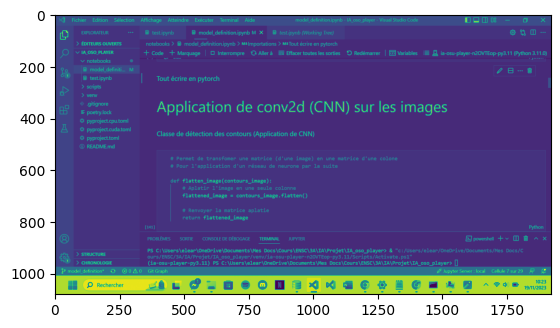

In [4]:
# A supprimer, verification du fonctionnement
screenshots = test_recuperation_image()
print(np.array(screenshots[-1]).shape)
imgplot = plt.imshow(screenshots[-1])
plt.show()

Tout écrire en pytorch

# Application de conv2d (CNN) sur les images

Classe de détection des contours (Application de CNN)

In [141]:
# Permet de transfomer une matrice (d'une image) en une matrice d'une colone
# Pour l'application d'un réseau de neurone par la suite

def flatten_image(contours_image):
    # Aplatir l'image en une seule colonne
    flattened_image = contours_image.flatten()

    # Renvoyer la matrice aplatie
    return flattened_image

In [148]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

class ContourDetector(nn.Module):
    def __init__(self):

        super(ContourDetector, self).__init__()

        # Couches de convolution
        self.Conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.Conv2 = nn.Conv2d(32, 1, kernel_size=3, stride=2, padding=1) # : division de la taille de la matrice de contours par 2, je trouve ça bien comme résultat

        # Couches de pooling
        self.Pool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0) # division de la taille de la matrice de contours par 4(stride ici a 2 et a la 2e couche de conv stride à 1)
        self.Flat=nn.Flatten()


    def forward(self, x):
        # Passe avant les couches de convolution
        x = self.Pool(F.relu(self.Conv1(x)))
        z = self.Pool(F.relu(self.Conv2(x)))

        y = self.Flat(z)
        print("Dimensions avec shape:", y.shape)

        return z,y

In [ ]:
Initialisation du modèle

In [149]:
# Initialiser le modèle
contour_model = ContourDetector()
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, ], [0.5, ])])
# Afficher le modèle
print(contour_model)

ContourDetector(
  (Conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2): Conv2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (Flat): Flatten(start_dim=1, end_dim=-1)
)


Test du modèle CNN, à supprimer

Dimensions avec shape: torch.Size([1, 518400])


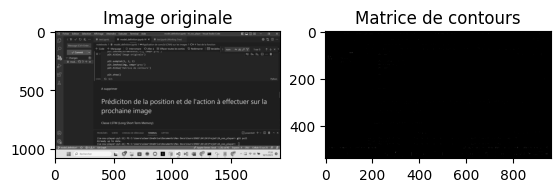

In [150]:
# # Test de la fonction

screenshots = test_recuperation_image()
image = screenshots[-1]
image = transform(image)

contours_matrix, y = contour_model(image)
img = contours_matrix.detach().numpy()[0]

# Affichage de l'image originale et de la matrice de contours
plt.subplot(1, 2, 1)
plt.imshow(screenshots[-1], cmap='gray')
plt.title('Image originale')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.title('Matrice de contours')

plt.show()

# Traitement des récompenses

Detection du score et de la précision

Il faut installer pytesseract et Tesseract OCR pour utiliser la reconnaissance de texte. 
Installez Tesseract OCR puis dans le bash du projet lancez la commande 'pip install pytesseract'

In [54]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import re
import pytesseract

def detect_numbers(image):
    # Charger un modèle Faster R-CNN pré-entraîné
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    # Récupérer les dimensions originales de l'image
    width, height = image.size

    # Définir les coordonnées de la région à traiter (1/4 de la longueur et 1/4 de la hauteur)
    region_left = int(0.75 * width)
    region_top = 0
    region_right = width
    region_bottom = int(0.25 * height)

    # Extraire la région à traiter
    region = image.crop((region_left, region_top, region_right, region_bottom))
    plt.imshow(region)
    image.show()

    # Appliquer les transformations nécessaires à la région
    region_tensor = F.to_tensor(region)
    region_tensor = region_tensor.unsqueeze(0)  # Ajouter une dimension pour le lot

    # Effectuer l'inférence sur la région
    with torch.no_grad():
        prediction = model(region_tensor)

    # Convertir la région en niveaux de gris
    region_gray = region.convert('L')

    # Utiliser Tesseract OCR pour reconnaître le texte dans la région
    result = pytesseract.image_to_string(region_gray)

    # Filtrer les caractères pour ne conserver que les nombres, le caractère "%", et le retour à a ligne pour séparer les 2 résultats
    filtered_result = re.sub(r'[^0-9%\n,.]', '', result)

    return prediction, region, filtered_result  # Retourner également le résultat filtré pour une utilisation ultérieure

Test de la fonction de prédiction des nombres, à supprimer

Résultat de la reconnaissance de nombres : 00201

980,36%



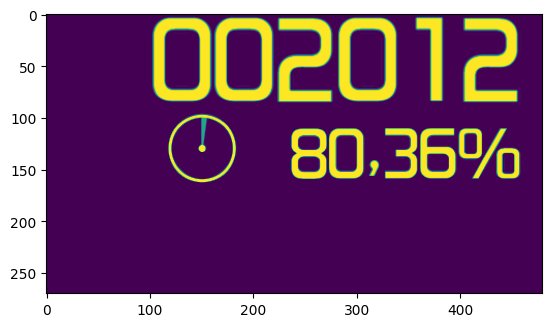

In [55]:
# Test de la foncion detect_numbers

screenshots = test_recuperation_image()
image = screenshots[-1]

# Convertir le screenshot en tableau NumPy
image_np = np.array(image)

# Convertir le screenshot en objet PIL.Image
pil_image = Image.fromarray(image_np)

# Appeler la fonction de détection
predictions, region, filtered_result = detect_numbers(pil_image)

print("Résultat de la reconnaissance de nombres :", filtered_result)

Extraction du score et de la précision

In [56]:
def extraire_score_precision(filtered_result):
    # Fonction pour extraire le score et la précision à partir du filtered_result

    # Extraire le score (le score étant sur la première ligne)
    lignes = filtered_result.split('\n')
    score_str = lignes[0].strip().split()[-1]
    score = int(score_str)

    # Extraire la précision (la précision étant sur la deuxième ligne)
    precision_str = lignes[2].strip().replace('%', '')
    precision_str = precision_str.replace(',', '.')  # Remplacer la virgule par un point
    precision = float(precision_str)

    return score, precision

Test de la fonction extraire_score_precision, à supprimer

In [64]:
score, precision = extraire_score_precision(filtered_result)
print("Score :", score)
print("Precision :", precision)

Score : 201
Precision : 980.36


Calcul de la différence de score et de précision entre 2 instants

In [62]:
def difference_scores_precisions(filtered_result_precedente, filtered_result_actuelle):
    # Extraire le score et la précision des prédictions
    score_precedent, precision_precedente = extraire_score_precision(filtered_result_precedente)
    score_actuel, precision_actuelle = extraire_score_precision(filtered_result_actuelle)

    # Calculer la différence du score et de la précision
    difference_score = score_actuel - score_precedent
    difference_precision = precision_actuelle - precision_precedente

    return difference_score, difference_precision

Test de la fonction difference_scores_precisions, à supprimer

Résultat de la reconnaissance de nombres de l'image précédente : 009118

100,00%

Résultat de la reconnaissance de nombres de l'image actuelle : 009306

100,00%

Score de l'image actuelle : 9306
Precision de l'image actuelle : 100.0
Score de l'image précédente : 9118
Precision de l'image précédente : 100.0
Différence du score : 188
Différence de la précision : 0.0


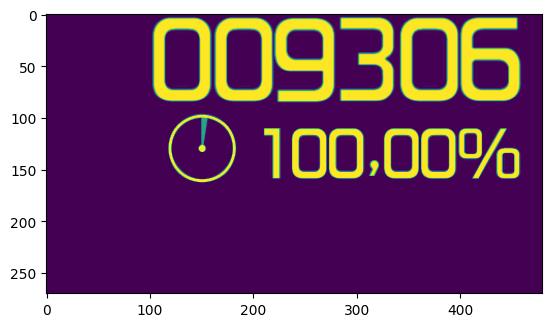

In [65]:
# Récupération des screenshots
screenshots = test_recuperation_image()
image_precedente = screenshots[-8]
image_actuelle = screenshots[-1]

# Convertir les screenshots en tableau NumPy
image_precedente_np = np.array(image_precedente)
image_actuelle_np = np.array(image_actuelle)

# Convertir les screenshots en objet PIL.Image
pil_image_precedente = Image.fromarray(image_precedente_np)
pil_image_actuelle = Image.fromarray(image_actuelle_np)

# Appeler la fonction de détection
prediction_precedente, region_precedente, filtered_result_precedente = detect_numbers(pil_image_precedente)
prediction_actuelle, region_actuelle, filtered_result_actuelle = detect_numbers(pil_image_actuelle)

# Afficher les résultats de la fonction de prédiction
print("Résultat de la reconnaissance de nombres de l'image précédente :", filtered_result_precedente)
print("Résultat de la reconnaissance de nombres de l'image actuelle :", filtered_result_actuelle)

# Extraction du score et de la précision des prédictions faites sur les images (pas obligatoire car fait dans la fonction extraire_score_precision)
score_actuel, precision_actuelle = extraire_score_precision(filtered_result_actuelle)
print("Score de l'image actuelle :", score_actuel)
print("Precision de l'image actuelle :", precision_actuelle)
score_precedent, precision_precedente = extraire_score_precision(filtered_result_precedente)
print("Score de l'image précédente :", score_precedent)
print("Precision de l'image précédente :", precision_precedente)

# Test de la fonction difference_scores_precisions
difference_score, difference_precision = difference_scores_precisions(filtered_result_precedente, filtered_result_actuelle)

# Afficher les résultats du test, cad de la différence du score et de la précision entre les deux images
print("Différence du score :", difference_score)
print("Différence de la précision :", difference_precision)

# Prédiciton de la position et de l'action à effectuer sur la prochaine image

Classe LSTM (Long Short Term Memory) 

In [ ]:
import torch.nn as nn

class MouseActionLSTM(nn.Module):
    """
    Classe définissant un modèle LSTM pour la prédiction des actions de la souris.
    
    Elle utilise une couche LSTM suivie d'une couche totalement connectée.
    Elle prend en compte une entrée composée d'une image aplatie (flatten) et de 6 valeurs supplémentaires : 
        - position x de la souris
        - position y de la souris
        - 0 (1 si la souris clique, mais a fini son action à ce moment)
        - 1 si on est en train de maintenir le clique, 0 sinon
        - 0 (1 si on fini de cliquer, mais a fini son action)
        - 1 si on fait rien, 0 sinon 

    Paramètres :
    - input_size : Taille de l'entrée du modèle.
    - hidden_size : Taille de la couche cachée LSTM.
    - output_size : Taille de la sortie du modèle.

    Méthodes :
    - forward : Définit le passage avant du modèle.
    """

    def __init__(self, input_size, hidden_size, output_size):
        # Appeler le constructeur de la classe parente
        super(MouseActionLSTM, self).__init__()

        # Couche LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Couche dnese totalement connectée
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x est l'entrée du modèle

        # Passage à travers la couche LSTM
        lstm_out, _ = self.lstm(x)

        # Ne prendre que la sortie du dernier pas de temps
        lstm_out = lstm_out[:, -1, :]

        # Passage à travers la couche totalement connectée
        output = self.fc(lstm_out)

        # Renvoyer la sortie du modèle
        return output

Instanciation du modèle

In [ ]:
input_size = 2073600 + 6  # Taille de l'entrée : flattened_image + les 6 informations de la souris
hidden_size = 64  # Taille de la couche cachée LSTM
output_size = 6  # Taille de la sortie : 6 pour les actions possibles

# Instanciation du modèle
model = MouseActionLSTM(input_size, hidden_size, output_size)

Définition de la fonction de perte et l'optimiseur (à checker)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Entrainement du modèle (à checker)

In [ ]:
# Entraîner le modèle avec vos données d'entraînement
# Les données d'entraînement doivent être dans train_data et train_labels

num_epochs = 10
for epoch in range(num_epochs):
    # Convertir les données en tenseurs PyTorch
    inputs = torch.tensor(train_data, dtype=torch.float32)
    labels = torch.tensor(train_labels, dtype=torch.long)

    # Réinitialiser les gradients
    optimizer.zero_grad()

    # Passage avant
    outputs = model(inputs)

    # Calculer la perte
    loss = criterion(outputs, labels)

    # Passage arrière et optimisation
    loss.backward()
    optimizer.step()

    # Afficher la perte à chaque époque
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

NameError: name 'train_data' is not defined